In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product
import glob
from PIL import Image

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

import flickr_api
from flickr_api import Photo
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
import torch

from dataset.load import LoadDataset
from dataset.utils import load_credentials
from utils.vis import thumb_grid
from utils.geojson import GeoJson
from clustering.dbscan import MultiFeatureDBSCAN
from clustering.embedding import WSL, VGG16

api_key, api_secret = load_credentials()
flickr_api.set_keys(api_key=api_key, api_secret=api_secret)

# Multifeature DBSCAN

In [3]:
params = {
    "dataset": LoadDataset("./data/paris_1000.h5"),
    "model": VGG16(-5),
    "weights": (0.33, 0.33, 1-2*0.33),
    #"weights": (0.5, 0.5, 0.0),
    #"weights": (1.0, 0.0, 0.0),
    "max_data": 500,
    "eps": 0.13,
    "min_samples": 2
}
model = MultiFeatureDBSCAN(**params)
model.fit()

Get data from hdfs5 file...
Images to embeddings...
Vectorization of tags...
Final training set: (500, 2) (500, 500) (500, 500)
Compute distance matrix of locations...
Compute distance matrix of embeddings...
Compute distance matrix of tags...
dist_matrix: 0.0 0.4960548678552854+-0.09064534362819504 0.8099350262939938
Training DBSCAN...
Result: 40 clusters
Counts: 2 5.425+-5.598604736896506 24


Silhouette 0.0374985674734292, Calinski 15.618704960953517


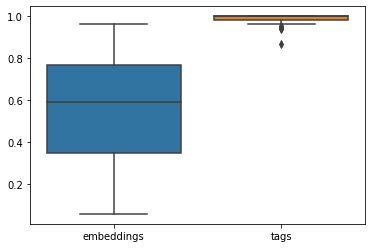

In [4]:
metrics = model.results()
print(f"Silhouette {metrics['sil']}, Calinski {metrics['cha']}")
df = pd.DataFrame({
    "embeddings": [metrics["embeddings_sims"][l] for l in metrics["embeddings_sims"].keys()],
    "tags": [metrics["tags_sims"][l] for l in metrics["tags_sims"].keys()]
})
sns.boxplot(data=df)

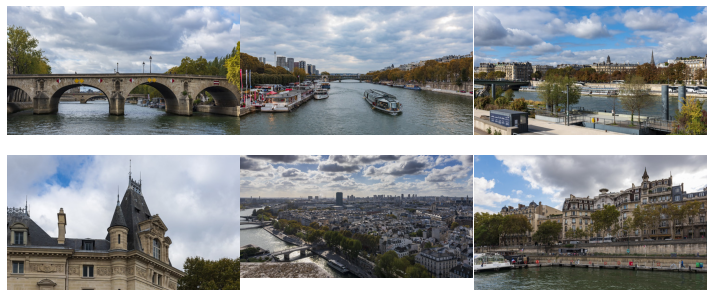

Embeddings sim: 0.2284114956855774, Tags sim: 1.0000000000000002


In [5]:
# Get images in clusters
cluster_imgs = {}
for label in set(model.labels):
    if label == -1: continue
    photos_id = [model.idx[i] for i in range(model.labels.shape[0]) if model.labels[i] == label]
    cluster_imgs[label] = []
    subset = np.random.choice(len(photos_id), size=min(len(photos_id), 6), replace=False)
    for photo_id in [photos_id[i] for i in subset]:
        _, img, _ = params["dataset"].get_id(int(photo_id))
        cluster_imgs[label].append(img)

# Visualize photos from the same cluster
cluster_label = 15
fig = thumb_grid(cluster_imgs[cluster_label], (2, 3))
fig.set_size_inches(10, 10)
fig.tight_layout()
plt.show()
print(f"Embeddings sim: {metrics['embeddings_sims'][cluster_label]}, Tags sim: {metrics['tags_sims'][cluster_label]}")

In [6]:
pairs = [(model.idx[i], model.labels[i]) for i in range(model.labels.shape[0])]
GeoJson(params["dataset"], pairs).save_to("geojson-viewer/data.geojson")

# Validation

In [5]:
def get_all_annotation():
    all_files = glob.glob("./data/annotations/annotations_*.csv")
    li = []
    for filename in all_files:
        df = pd.read_csv(filename)
        li.append(df)
    df = pd.concat(li, axis=0, ignore_index=True)
    # If duplicates, keep the most voted label
    df = df.groupby(["id1","id2"]).agg(lambda x: x.value_counts().index[0]).reset_index()
    return df

def get_y_true_pred(label_lookup, val_set):
    y_true, y_pred = [], []
    for id1, id2, together in val_set:
        # Check if id1 and id2 have been predicted
        label_of_id1 = label_lookup.get(id1, None)
        label_of_id2 = label_lookup.get(id2, None)
        if label_of_id1 is None or label_of_id2 is None:
            continue

        # Check if they are in the same cluster, except if they are in -1
        y_true.append(together)
        if label_of_id1 == label_of_id2 and label_of_id1 != -1:
            y_pred.append(1)
        else:
            y_pred.append(0)

    return y_true, y_pred

In [ ]:
label_of_id = {int(model.idx[i]): label for i, label in enumerate(model.labels)}
val_set_df = get_all_annotation()
val_set = val_set_df.values.tolist()
y_true, y_pred = get_y_true_pred(label_of_id, val_set)
print("accuracy_score:", accuracy_score(y_true, y_pred))
print("balanced_accuracy_score:", balanced_accuracy_score(y_true, y_pred))
print("f1_score:", f1_score(y_true, y_pred))
print("confusion_matrix:\n", confusion_matrix(y_true, y_pred))

# Grid Search

In [3]:
cnn_model = VGG16(-5)
dataset = LoadDataset("./data/paris_1000.h5")
max_data = 500

In [6]:
grid_params = [
    {"dataset": dataset, "model": cnn_model, "weights": (1.0, 0.0, 0.0), "max_data": max_data, "verbose": False},
    # {"dataset": dataset, "model": cnn_model, "weights": (0.0, 1.0, 0.0), "max_data": max_data, "verbose": False},
    # {"dataset": dataset, "model": cnn_model, "weights": (0.0, 0.0, 1.0), "max_data": max_data, "verbose": False},
    # {"dataset": dataset, "model": cnn_model, "weights": (0.33, 0.33, 1-2*0.33), "max_data": max_data, "verbose": False},
]

val_set_df = get_all_annotation()
val_set = val_set_df.values.tolist()

results = pd.DataFrame()
search_space = list(product(grid_params, np.arange(0.01, 0.20, 0.02), np.arange(2, 10, 1)))
print(f"Experiments: {len(search_space)}")
for i, candidate in enumerate(search_space):
    if i % 10 == 0: print(f"{i}/{len(search_space)}...")
    params, eps, min_samples = candidate
    params.update({"eps": eps, "min_samples": min_samples})
    model = MultiFeatureDBSCAN(**params)
    model.fit()
    metrics = model.results()
    label_of_id = {int(model.idx[i]): label for i, label in enumerate(model.labels)}
    y_true, y_pred = get_y_true_pred(label_of_id, val_set)
    metrics.update({
        "accuracy_score": accuracy_score(y_true, y_pred),
        "balanced_accuracy_score": balanced_accuracy_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred)
    })
    metrics.update(params)
    results = results.append(metrics, ignore_index=True)

print("done")
results = results.drop(["dataset", "model"], axis=1)
results.sample(n=min(3, results.shape[0]))

Experiments: 80
0/80...


KeyboardInterrupt: 

In [ ]:
results["embeddings_sims_mean"] = results["embeddings_sims"].apply(lambda sims: np.mean([v for _,v in sims.items()]))
results["tags_sims_mean"] = results["tags_sims"].apply(lambda sims: np.mean([v for _,v in sims.items()]))

best = results\
    .sort_values(by=["balanced_accuracy_score", "n_clusters", "sil", "embeddings_sims_mean", "tags_sims_mean"], ascending=False)\
    .groupby("weights").head(1)
best[["weights", "eps", "min_samples", "embeddings_sims_mean", "tags_sims_mean", "sil", "balanced_accuracy_score", "n_clusters"]]

In [ ]:
results[results["weights"] == (0.33, 0.33, 0.33999999999999997)]\
    .sort_values(by=["balanced_accuracy_score", "n_clusters", "sil", "embeddings_sims_mean", "tags_sims_mean"], ascending=False)\
    [["weights", "eps", "min_samples", "embeddings_sims_mean", "tags_sims_mean", "sil", "n_clusters", "balanced_accuracy_score"]].head(30)